### Notebook based on:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia <br>
https://www.kaggle.com/code/karan842/pneumonia-detection-transfer-learning-95-acc

What is Pneumonia?

    Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

    Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.


In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

2022-05-20 19:19:49.553064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 19:19:49.553093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!ls ../../data/chest_xray

chest_xray  __MACOSX  test  train  val


In [3]:
train_dir = "../../data/chest_xray/train"
test_dir = "../../data/chest_xray/test"
val_dir = "../../data/chest_xray/val"

In [4]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../../data/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../../data/chest_xray/train/PNEUMONIA"
normal_lungs = os.listdir("../../data/chest_xray/train/NORMAL")
normal_lungs_dir = "../../data/chest_xray/train/NORMAL"

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


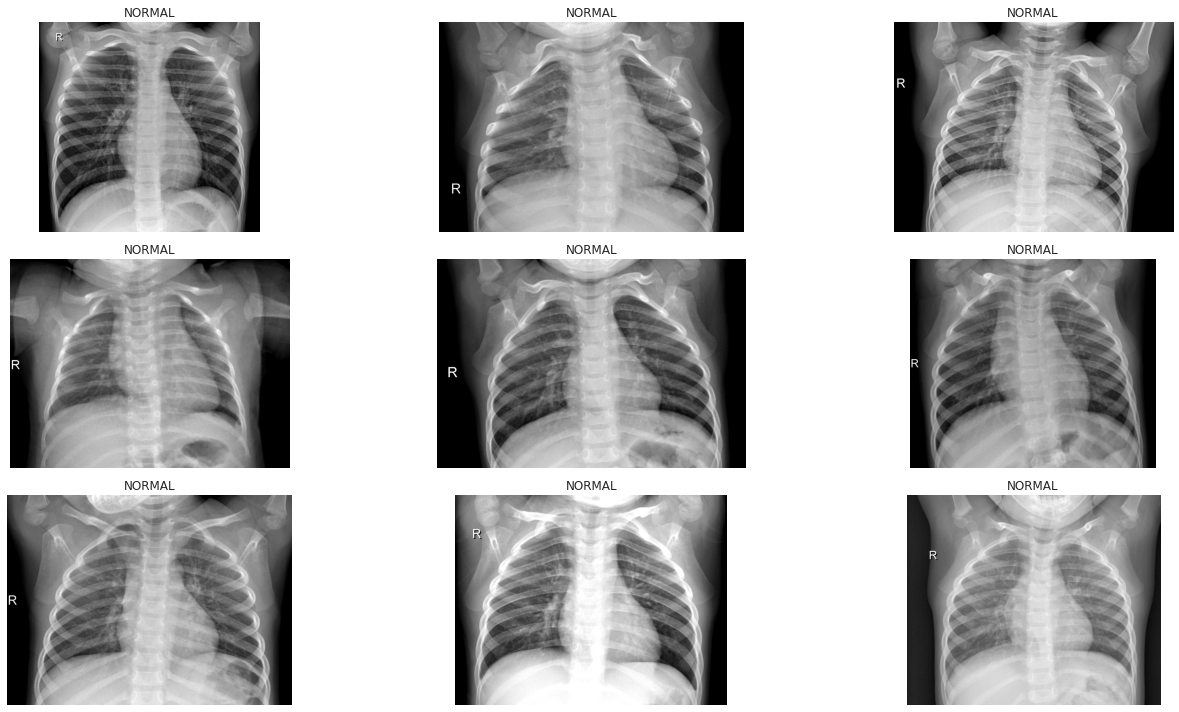

In [5]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_lungs_dir, normal_lungs[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

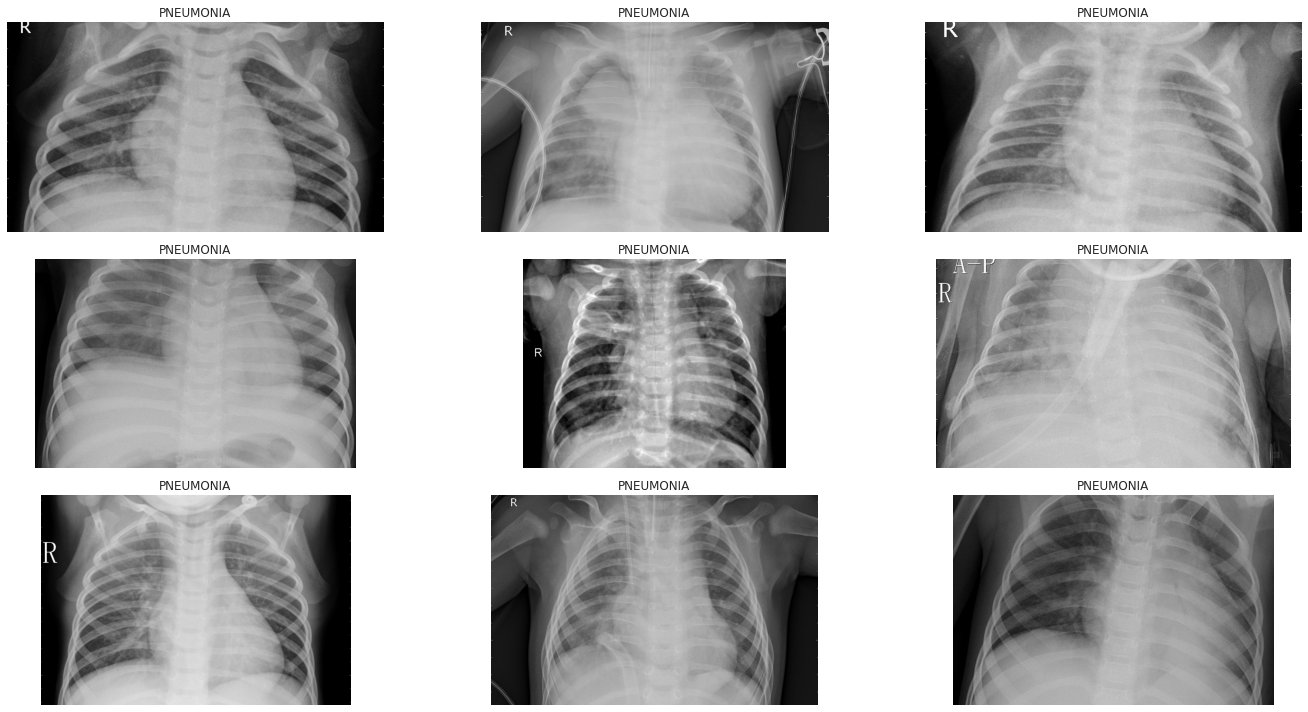

In [6]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

In [7]:
import glob
# Get list of files for NORMAL and PNEUMONIA jpeg images
pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [8]:
data_pneumonia = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

In [9]:
data_pneumonia.describe()

,class
count,5216.000000
mean,0.742906
std,0.437073
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
# Checking if any value in the dataframe is null
data_pneumonia.isnull().values.any()

False

In [11]:
# Checking types of values
print(data_pneumonia.dtypes)

class    int64
dtype: object


In [12]:
# Labels are: 0 - NORMAL || 1 - PNEUMONIA
data_pneumonia["class"].value_counts()

1    3875
0    1341
Name: class, dtype: int64

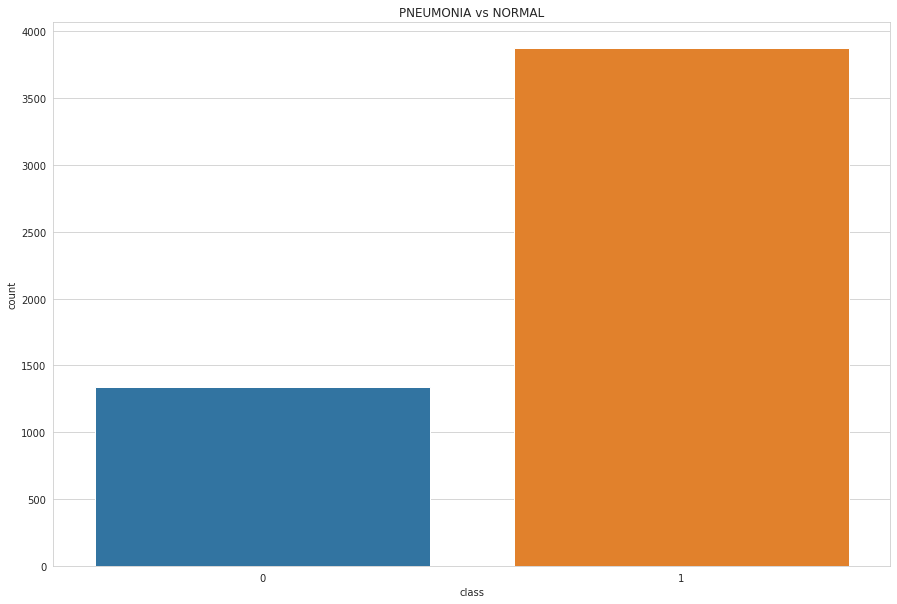

In [14]:
plt.figure(figsize=(15,10))
sns.countplot(data_pneumonia['class'],data=data_pneumonia)
plt.title('PNEUMONIA vs NORMAL')
plt.show()

## Data Augmentation
- Using `ImageDataGenerator`, to augment our images so as to create a larger dataset for our model to train on.

2. Also deal wit imbalances number of data points of the given classes.


In [15]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [16]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=8,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=1,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = img_Datagen.flow_from_directory(test_dir,
                                       batch_size=1,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
img, label = next(train)
img.shape

(8, 256, 256, 3)

In [18]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

2022-05-20 19:20:23.738933: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-20 19:20:23.738963: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-05-20 19:20:23.741061: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Check the architecture of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [20]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 35s 335ms/step - loss: 0.4480 - accuracy: 0.7775 - val_loss: 0.5915 - val_accuracy: 0.6875
Epoch 2/30
100/100 [==============================] - 32s 320ms/step - loss: 0.3548 - accuracy: 0.8225 - val_loss: 0.6470 - val_accuracy: 0.7500
Epoch 3/30
100/100 [==============================] - 32s 321ms/step - loss: 0.3209 - accuracy: 0.8575 - val_loss: 0.5692 - val_accuracy: 0.7500
Epoch 4/30
100/100 [==============================] - 32s 314ms/step - loss: 0.2736 - accuracy: 0.8813 - val_loss: 0.7251 - val_accuracy: 0.6875
Epoch 5/30
100/100 [==============================] - 31s 309ms/step - loss: 0.3125 - accuracy: 0.8662 - val_loss: 0.5115 - val_accuracy: 0.6875
Epoch 6/30
100/100 [==============================] - 31s 306ms/step - loss: 0.2852 - accuracy: 0.8737 - val_loss: 0.6538 - val_accuracy: 0.7500
Epoch 7/30
100/100 [==============================] - 31s 305ms/step - loss: 0.2844 - accuracy: 0.8825 - val_loss: 0.4244 - val_ac

In [21]:
# Evaluating the model on traina and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

652/652 [==============================] - 191s 293ms/step - loss: 0.2530 - accuracy: 0.8840
Train Loss:  0.2529507875442505
Train Accuracy:  0.8840107321739197


In [22]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

624/624 [==============================] - 31s 50ms/step - loss: 0.5958 - accuracy: 0.7532
Test Loss:  0.595809817314148
Test Accuracy:  0.7532051205635071


Text(0.5, 1.0, 'Accuracy Evolution')

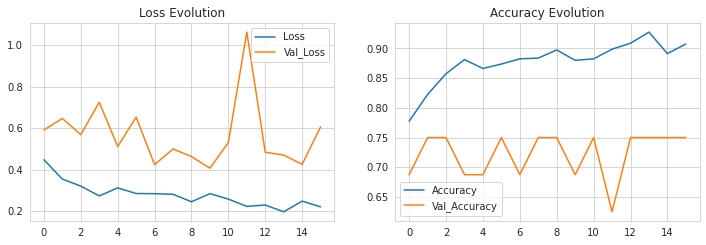

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

Confusion matrix


[Text(0, 0.5, 'NORMAL'), Text(0, 1.5, 'PNEUMONIA')]

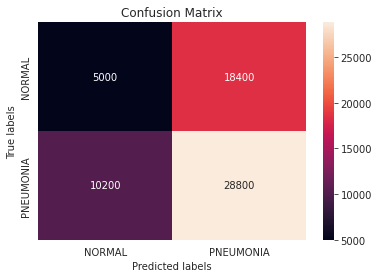

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(test)

print("Confusion matrix")
cm = confusion_matrix(test.classes, pred>0.5)*100
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])

In [55]:
print("Classification Report: \n")
print(classification_report(test.classes, pred>0.5))

Classification Report: 

              precision    recall  f1-score   support

           0       0.33      0.21      0.26       234
           1       0.61      0.74      0.67       390

    accuracy                           0.54       624
   macro avg       0.47      0.48      0.46       624
weighted avg       0.50      0.54      0.51       624

